![image.png](https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2023/02/01/20/24/healthy-brain-and-brain-with-alzheimers-8-col-3398230-002-0.jpg)
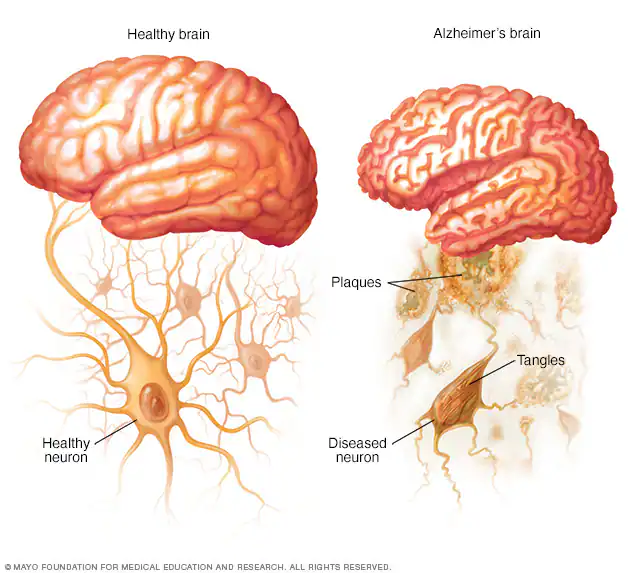
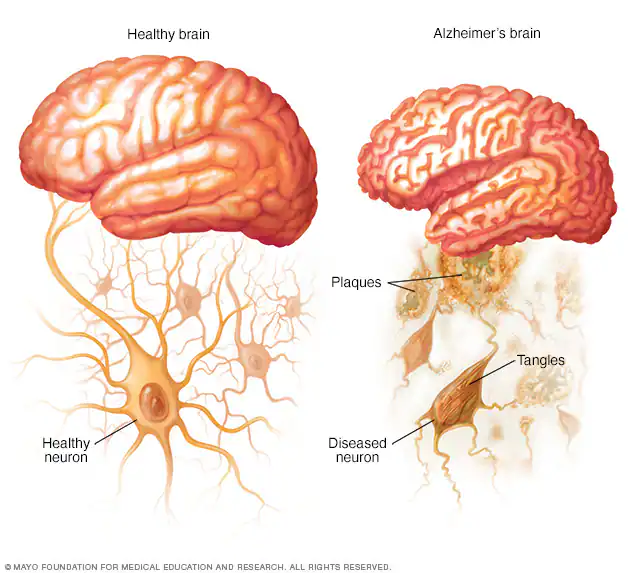

## Problem Statement

We seek to develop a deep learning model that would label brain MRI scans into four stages of Alzheimer's disease:

* Non-Demented

* Very Mild Demented

* Mild Demented

* Moderate Demented


With the **Augmented Alzheimer MRI Dataset**, the model would learn to recognize patterns in brain scans and accurately predict the level of cognitive impairment. This is a **multi-class image classification** problem, which will facilitate early diagnosis and clinical decision-making.



Main tools

In [40]:
!pip install efficientnet_pytorch -q

In [53]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from PIL import Image
from collections import Counter
import numpy as np
from tqdm import tqdm


import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
from efficientnet_pytorch import EfficientNet


from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)


Get class labels

In [19]:
dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"
classes = os.listdir(dataset_path)
print("Classes:", classes)


Classes: ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']


Inspect class counts

Class Distribution:
ModerateDemented: 6464 images
NonDemented: 9600 images
VeryMildDemented: 8960 images
MildDemented: 8960 images


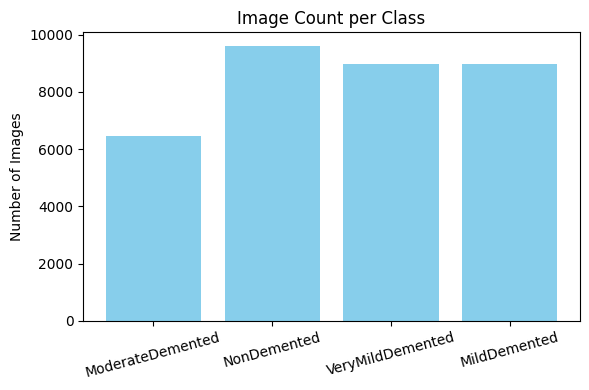

In [25]:
class_counts = {}
for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    class_counts[cls] = len(os.listdir(cls_path))

print("Class Distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

# Bar chart
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Image Count per Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


The data are semi-balanced, no need to do more augmentations.

Show some examples

In [26]:
def show_samples(dataset_path, classes, samples_per_class=3):
    num_classes = len(classes)
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))

    if num_classes == 1:  # Handle single-class case
        axes = [axes]

    for row_idx, cls in enumerate(classes):
        cls_path = os.path.join(dataset_path, cls)
        images = sorted(os.listdir(cls_path))[:samples_per_class]

        for col_idx in range(samples_per_class):
            ax = axes[row_idx][col_idx] if num_classes > 1 else axes[col_idx]
            try:
                img_path = os.path.join(cls_path, images[col_idx])
                img = Image.open(img_path).convert("L")  # Grayscale
                ax.imshow(img, cmap='gray')
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                ax.text(0.5, 0.5, 'Image\nError', ha='center', va='center')
                ax.set_facecolor('lightgray')

            ax.axis('off')
            if col_idx == 0:
                ax.set_title(cls, fontsize=10, loc='left')

    plt.suptitle("Sample Images per Class", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for title
    plt.show()


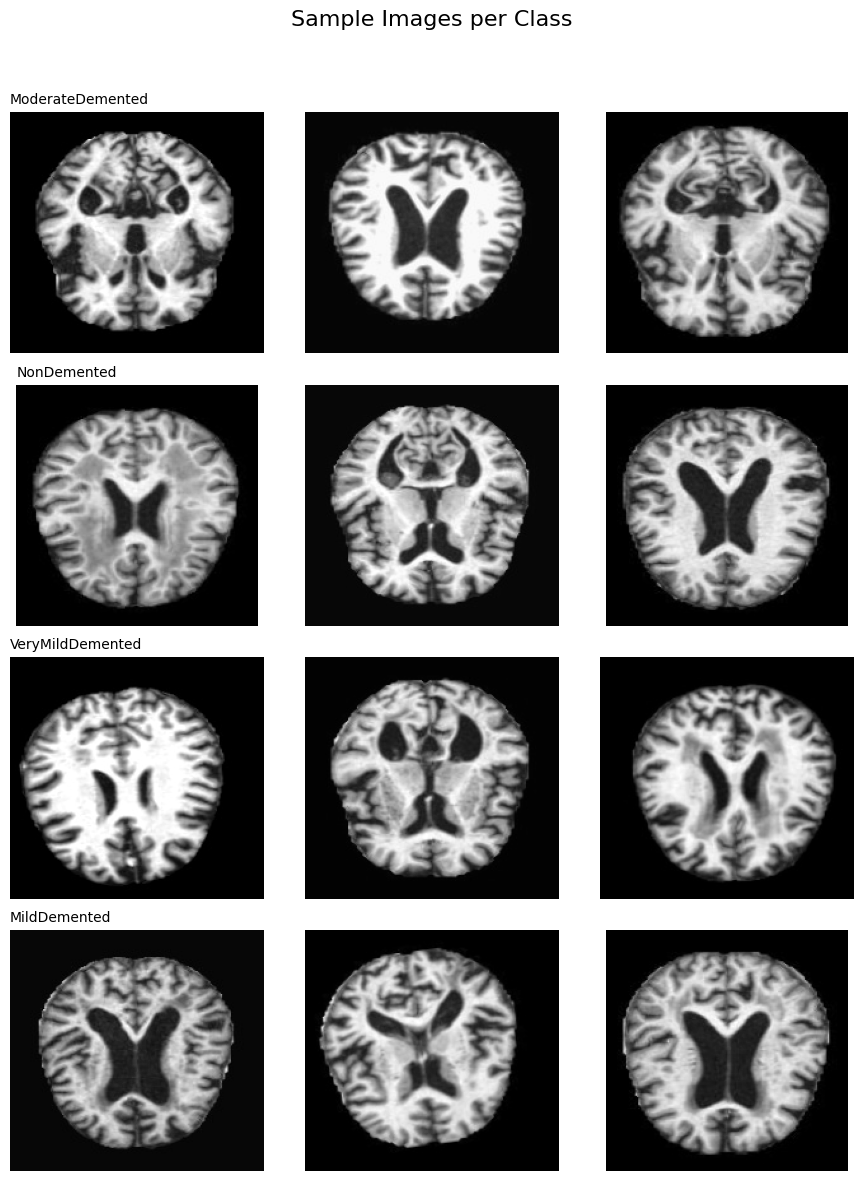

In [27]:
show_samples(dataset_path, classes)


## Dataset Preparation

Create the transforms. since the data is augmented, we will only resize it

In [29]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()           
])


In [30]:
root_dir = '/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset'
full_dataset = datasets.ImageFolder(root=root_dir, transform=transform)

In [31]:
print("Class mapping:", full_dataset.class_to_idx)

Class mapping: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [32]:
# Split into train/val/test (e.g., 70%/15%/15%)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

In [33]:
batch_size = 32

In [34]:
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


no, we have batches of shape (32, 3, 224, 224) for each batch, along with the 32 labels

In [39]:
for i in train_loader:
    print(i[0].shape, i[1].shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


## Choose Model

In [42]:
# I tested enet b3, so I will use it to trian the classifier.
model = EfficientNet.from_pretrained('efficientnet-b3')

Loaded pretrained weights for efficientnet-b3


In [43]:
# Modify the classifier head
num_classes = 4 
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)

In [45]:
# Add dropout for better generalization
model._fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, num_classes)
)


In [46]:
# uncomment the code below to see model architecture
# model

## Train The Model

In [47]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
        """
        Args:
            model (torch.nn.Module): Your model.
            train_loader (DataLoader): Training data loader.
            val_loader (DataLoader): Validation data loader.
            criterion: Loss function.
            optimizer: Optimizer.
            device: torch.device('cuda' or 'cpu').
            num_epochs (int): Number of epochs to train.
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.num_epochs = num_epochs

        # For recording training history
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }

    def fit(self):
        for epoch in range(1, self.num_epochs + 1):
            print(f"\nEpoch {epoch}/{self.num_epochs}")
            print("-" * 30)

            # ---- Training ----
            self.model.train()
            running_loss, correct_preds, total_preds = 0.0, 0, 0
            train_bar = tqdm(self.train_loader, desc='Training', leave=False)
            for images, labels in train_bar:
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # Accumulate stats
                batch_size = images.size(0)
                running_loss += loss.item() * batch_size
                preds = outputs.argmax(dim=1)
                correct_preds += (preds == labels).sum().item()
                total_preds += batch_size

                train_bar.set_postfix(loss=loss.item())

            epoch_train_loss = running_loss / total_preds
            epoch_train_acc  = correct_preds / total_preds * 100
            self.history['train_loss'].append(epoch_train_loss)
            self.history['train_acc'].append(epoch_train_acc)
            print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%")

            # ---- Validation ----
            self.model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                val_bar = tqdm(self.val_loader, desc='Validating', leave=False)
                for images, labels in val_bar:
                    images, labels = images.to(self.device), labels.to(self.device)

                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)

                    batch_size = images.size(0)
                    val_loss += loss.item() * batch_size
                    preds = outputs.argmax(dim=1)
                    val_correct += (preds == labels).sum().item()
                    val_total += batch_size

                    val_bar.set_postfix(loss=loss.item())

            epoch_val_loss = val_loss / val_total
            epoch_val_acc  = val_correct / val_total * 100
            self.history['val_loss'].append(epoch_val_loss)
            self.history['val_acc'].append(epoch_val_acc)
            print(f"Val   Loss: {epoch_val_loss:.4f} | Val   Acc: {epoch_val_acc:.2f}%")

        return self.history

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
device

device(type='cuda')

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [51]:
criterion = criterion.to(device)

In [52]:
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)
history = trainer.fit()


Epoch 1/5
------------------------------


Train Loss: 0.5884 | Train Acc: 74.77%


Val   Loss: 0.2818 | Val   Acc: 89.17%

Epoch 2/5
------------------------------


Train Loss: 0.1348 | Train Acc: 95.14%


Val   Loss: 0.0526 | Val   Acc: 98.04%

Epoch 3/5
------------------------------


Train Loss: 0.0464 | Train Acc: 98.47%


Val   Loss: 0.0356 | Val   Acc: 98.78%

Epoch 4/5
------------------------------


Train Loss: 0.0334 | Train Acc: 98.93%


Val   Loss: 0.0194 | Val   Acc: 99.31%

Epoch 5/5
------------------------------


Train Loss: 0.0233 | Train Acc: 99.22%


Val   Loss: 0.0206 | Val   Acc: 99.14%


## Evaluate The Model

In [54]:
class Evaluator:
    def __init__(self, model, test_loader, device, class_names=None):
        """
        Args:
            model (torch.nn.Module): Trained model.
            test_loader (DataLoader): DataLoader for test set.
            device (torch.device): 'cuda' or 'cpu'.
            class_names (list of str, optional): Names of the classes in order.
        """
        self.model = model.to(device)
        self.test_loader = test_loader
        self.device = device
        self.class_names = class_names

    def evaluate(self):
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in self.test_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                preds = outputs.argmax(dim=1).cpu().tolist()
                all_preds.extend(preds)
                all_labels.extend(labels.tolist())

        # Compute metrics
        acc = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        print("Classification Report:")
        print(classification_report(all_labels, all_preds, target_names=self.class_names))

        # Confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names,
                    yticklabels=self.class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()

        # Summary metrics
        metrics = {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        return metrics


Classification Report:
                  precision    recall  f1-score   support

ModerateDemented       1.00      1.00      1.00      1351
     NonDemented       1.00      1.00      1.00       940
VeryMildDemented       0.99      0.98      0.99      1409
    MildDemented       0.98      0.99      0.99      1399

        accuracy                           0.99      5099
       macro avg       0.99      0.99      0.99      5099
    weighted avg       0.99      0.99      0.99      5099



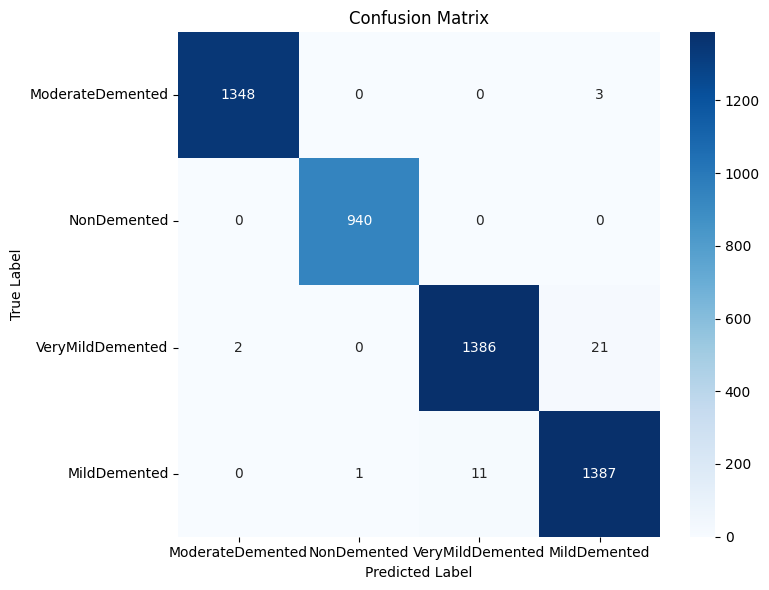

Test set metrics:
Accuracy: 0.9925
Precision: 0.9926
Recall: 0.9925
F1_score: 0.9925


In [56]:
evaluator = Evaluator(model, test_loader, device, classes)
test_metrics = evaluator.evaluate()

print("Test set metrics:")
for k, v in test_metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")


## Save

In [57]:
save_path = "model.pth"
torch.save(model, save_path)


![image.png](https://editablegifs.com/gif/thank-you-gif/thank-you-6.gif)
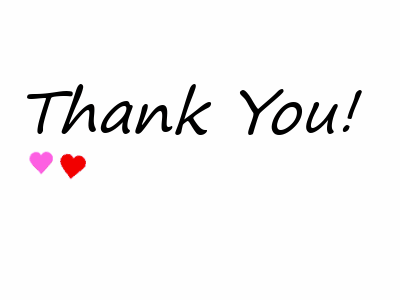
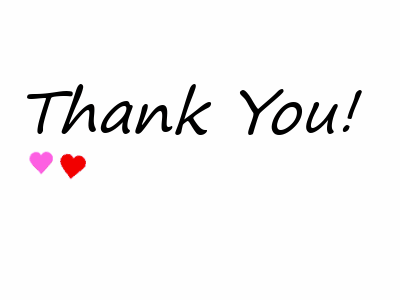